# Initial Setup

## Importing Libraries



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier

import re

## Setting Variables

In [2]:
plt.style.use('seaborn-paper')
plt.rcParams['figure.dpi'] = 128

In [3]:
RANDOM_STATE = 1
np.random.seed(RANDOM_STATE)

## Loading Data

In [4]:
url1 = 'https://raw.githubusercontent.com/joanamftavares/text-mining/main/data/dev_set.txt'
dev_set = pd.read_csv(url1, delimiter='\t')
dev_set

,sentence,emotion
0,What happens to the gold in our safe ?,4
1,Natural to get cold feet .,8
2,"Not very lucky , is he ?",7
3,I'm just a little anxious to get up there and ...,2
4,Did you think we don't know about your affair ...,1
...,...,...
995,All I ask of you is be careful .,4
996,"You don't like jazz , pal ?",7
997,Put it on .,1
998,Can you ever imagine [PERSON] being in a spot ...,7


In [5]:
url2 = 'https://raw.githubusercontent.com/joanamftavares/text-mining/main/data/training_set.txt'
train_set = pd.read_csv(url2, delimiter='\t')
train_set

,sentence,emotion
0,I'm too old to be traded in .,6
1,Mother said you could always tell a lady by he...,8
2,I always said I'd leave off when the time came .,6
3,He'll be safe with me .,2
4,Lay off .,1
...,...,...
13995,"Yes , Commissioner .",8
13996,The ring !,7
13997,That is my greatest and most enduring love .,5
13998,"When I came back from the war , I had a son .",5


# Baseline Preprocessing

In [6]:
## Uncomment these on first run
#nltk.download('omw-1.4')
#nltk.download('averaged_perceptron_tagger')


In [7]:
stop = text.ENGLISH_STOP_WORDS
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [8]:
def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

def baseline_preprocessing(df_, col, stop=[]):
    
    df = df_.copy()
    df['original'] = df[col]
    """
    Baseline preprocessing: 
        - lowercase
        - remove symbols (keep letters, ?, !)
        - remove stop words
        - use stemming
    """
    keep = ['?', '!']
    
    ## Lowercase
    df[col] = df[col].str.lower()
    
    ## Remove symbols
    df[col] = df[col].apply(lambda x: ''.join([re.sub(r'[\.;:,\"\'\/]','',x)]))
    
    ## Remove the extra space left before symbols
    ## e.g. "who are you ?" >> "who are you?"
    ## Not sure if this should be done, comment out if not
    df[col] = df[col].apply(lambda x: str.replace(x,' ?','?'))
    df[col] = df[col].apply(lambda x: str.replace(x,' !','!'))

    
    ## Remove stop words ?
    ## https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a
    
    if len(stop) > 0:
        df[col] = df[col].apply(lambda x: ' '.join([word for word in x.split(' ') if word not in (stop)]))
    
    ## Use Stemmer
    df[col] = df[col].apply(lambda x: stem_sentences(x) )
    
    ## Remove excess space
    df[col] = df[col].str.strip()
    
    return df

In [9]:
train_set_prep = baseline_preprocessing(train_set, 'sentence', stop)
train_set_prep.head(3)

,sentence,emotion,original
0,im old trade,6,I'm too old to be traded in .
1,mother said tell ladi hand,8,Mother said you could always tell a lady by he...
2,said id leav time came,6,I always said I'd leave off when the time came .


In [10]:
#stop

In [11]:
dev_set_prep = baseline_preprocessing(dev_set, 'sentence', stop)
dev_set_prep.head(3)

,sentence,emotion,original
0,happen gold safe?,4,What happens to the gold in our safe ?
1,natur cold feet,8,Natural to get cold feet .
2,lucki he?,7,"Not very lucky , is he ?"


In [12]:
count_chars = train_set_prep.copy()
count_chars['len'] = count_chars[['sentence']].astype(str).sum(axis=1).str.len()
count_chars['len'].describe()
count_chars.loc[count_chars['len']==0,:]

,sentence,emotion,original,len
163,,4,"Get her back for me , please .",0
446,,2,Me too .,0
454,,5,It was always you and me .,0
844,,2,There can be ...,0
1210,,2,"Mine , mine , mine , mine , mine , mine ...",0
...,...,...,...,...
13226,,1,Out .,0
13243,,5,I can do anything .,0
13573,,1,"No , we're not done but you are .",0
13619,,1,You ...,0


# Data Understanding

In [13]:
labels = {
    1: 'Anger',
    2: 'Anticipation',
    3: 'Digust',
    4: 'Fear',
    5: 'Joy',
    6: 'Sadness',
    7: 'Surprise',
    8: 'Trust',
}

In [14]:
X_train = train_set_prep['sentence']
Y_train = train_set_prep['emotion']

X_dev = dev_set_prep['sentence']
Y_dev = dev_set_prep['emotion']

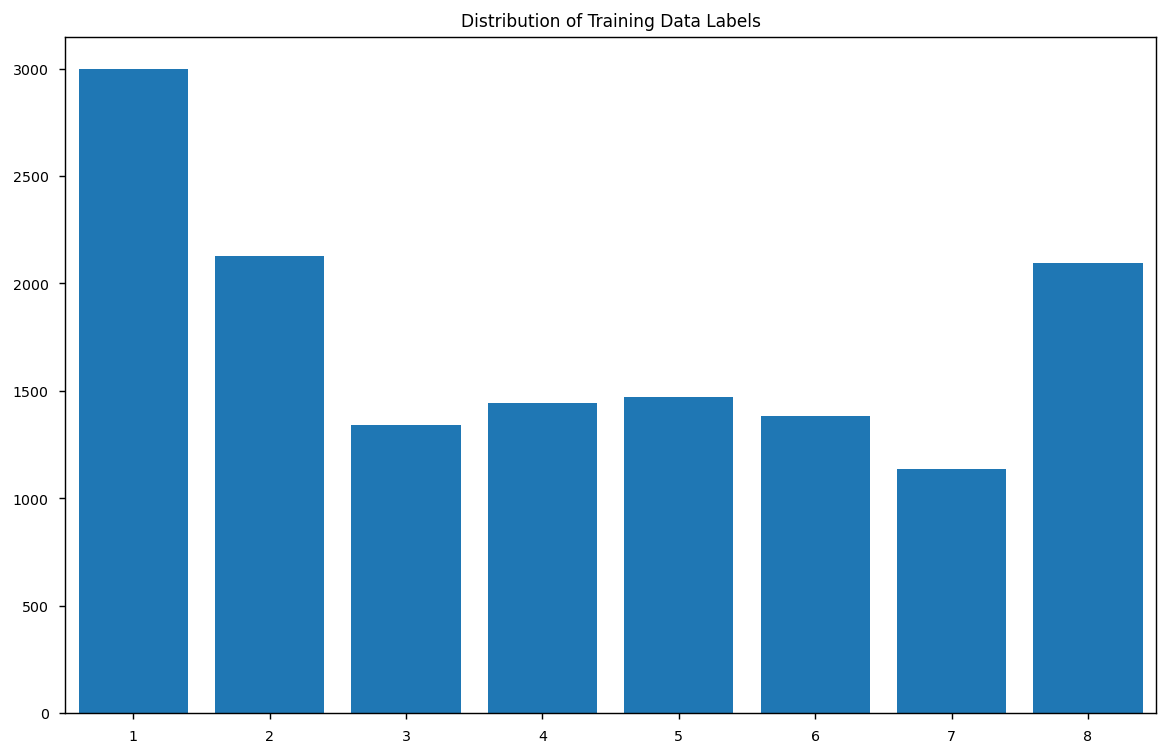

In [15]:
fig, ax = plt.subplots(figsize=(11,7))
y_counts = np.bincount(Y_train)
ax.bar(range(0,9), y_counts)
ax.set(xticks=range(1,9), xlim=[0.5, 8.5])

plt.title("Distribution of Training Data Labels")
plt.show()

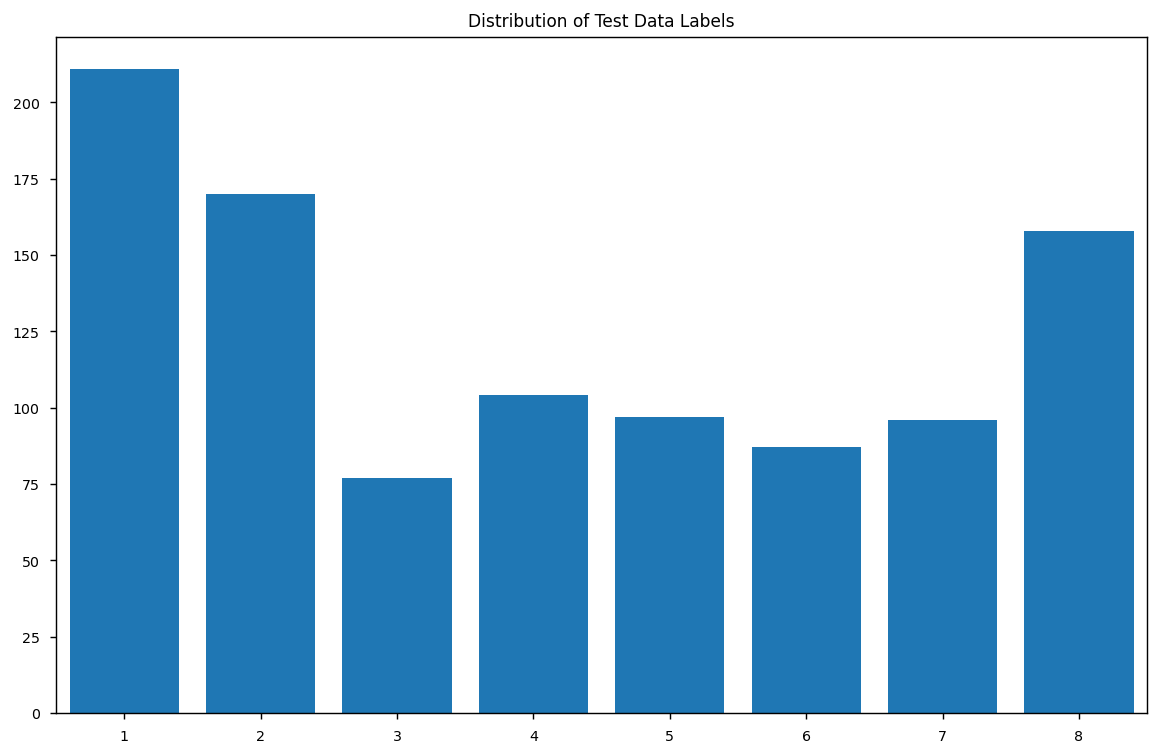

In [16]:
fig, ax = plt.subplots(figsize=(11,7))
y_counts = np.bincount(Y_dev)
ax.bar(range(0,9), y_counts)
ax.set(xticks=range(1,9), xlim=[0.5, 8.5])

plt.title("Distribution of Test Data Labels")
plt.show()

# Model Selection

In [17]:
f1labels = ["F1 " + labels[i+1] for i in range(len(labels))]
rclabels = ["Recall " + labels[i+1] for i in range(len(labels))]
pclabels = ["Precision " + labels[i+1] for i in range(len(labels))]
numlabels = [i+1 for i in range(len(labels))]


In [18]:
def get_scores(preds, label, cv_score, truth=Y_dev):
    return pd.DataFrame([[label,
               accuracy_score(truth, preds),
               recall_score(truth, preds, average='macro'),
               precision_score(truth, preds, average='macro'),
               f1_score(truth, preds, average='macro', ),
               cv_score,
               *(f1_score(truth, preds, average=None, labels=numlabels)),
               *(recall_score(truth, preds, average=None, labels=numlabels)),
               *(precision_score(truth, preds, average=None, labels=numlabels)),
            ]],
             columns=["Model", "Accuracy", "Recall", "Precision", "F1", "Train Accuracy", *f1labels, *rclabels, *pclabels ],
             index=[label]
        )
    
def print_scores(preds, gs_, Y=Y_dev):
    
    print("Best parameters: ")
    print(gs_.best_params_)
    print("------------------------")

    print("Accuracy:         ", round(accuracy_score(Y_dev, preds),4))
    print("Macro F1:         ", round(f1_score(Y_dev, preds, average='macro'),4))
    print("Macro Recall:     ", round(recall_score(Y_dev, preds, average='macro'),4))
    print("Macro Precision:  ", round(precision_score(Y_dev, preds, average='macro'),4))
    print("Best Train Score: ", round(gs_.best_score_,4))

    return

def plot_cm(preds, title, Y=Y_dev):
    cm_ = confusion_matrix(Y, preds)
    df_cm = pd.DataFrame(cm_, index=numlabels, columns=numlabels)
    plt.figure(figsize = (7,5))
    ax = sns.heatmap(df_cm, annot=True,cmap="Blues", fmt="d")
    ax.set_ylabel("True Label")
    ax.set_xlabel("Predicted Label")
    
    plt.title("Confusion Matrix: "+title, fontsize=12)
    plt.show()
    
    return



In [19]:
score_func = 'accuracy'

## Baseline KNN

In [20]:
pipe_knn = Pipeline([
    ('count', CountVectorizer()),     # CountVectorizer 
    ('classifier', KNeighborsClassifier()),  # 
])

## Uses values of default params as grid search values
grid_knn = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
}

gs_knn = GridSearchCV(pipe_knn, grid_knn, n_jobs=-1, cv=10, scoring=score_func)
gs_knn.fit(X_train, Y_train)
gs_knn_pred = gs_knn.predict(X_dev)


Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None}
------------------------
Accuracy:          0.245
Macro F1:          0.2037
Macro Recall:      0.2043
Macro Precision:   0.2268
Best Train Score:  0.2596


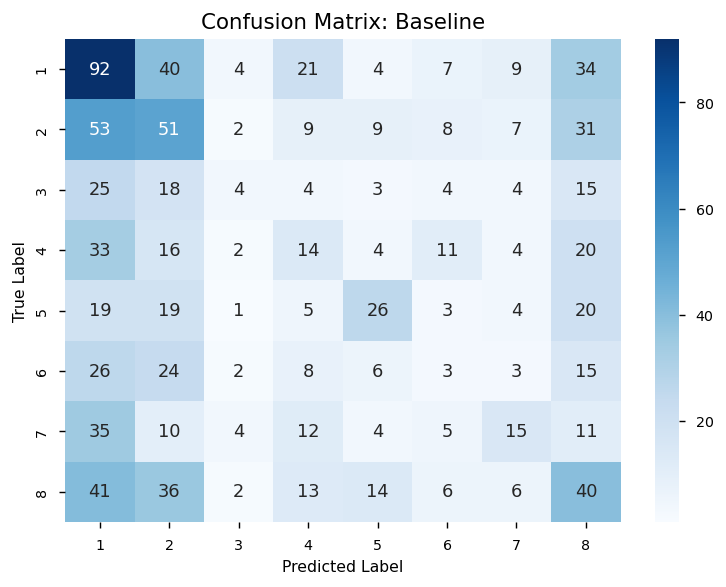

In [21]:
print_scores(gs_knn_pred, gs_knn)
scores = get_scores(gs_knn_pred, "KNN Baseline", gs_knn.best_score_)
plot_cm(gs_knn_pred, "Baseline")

## KNN Optimized

In [22]:
pipe_knno = Pipeline([
    ('count', CountVectorizer()),     # CountVectorizer 
    ('knn', KNeighborsClassifier()),  # 
])

## Uses values of default params as grid search values
grid_knno = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
    "knn__n_neighbors": [20],
    "knn__metric": ['cosine'],
    
}

gs_knno = GridSearchCV(pipe_knno, grid_knno, n_jobs=-1, cv=10, scoring=score_func)
gs_knno.fit(X_train, Y_train)
gs_knno_pred = gs_knno.predict(X_dev)


Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None, 'knn__metric': 'cosine', 'knn__n_neighbors': 20}
------------------------
Accuracy:          0.311
Macro F1:          0.2392
Macro Recall:      0.2504
Macro Precision:   0.2622
Best Train Score:  0.3019


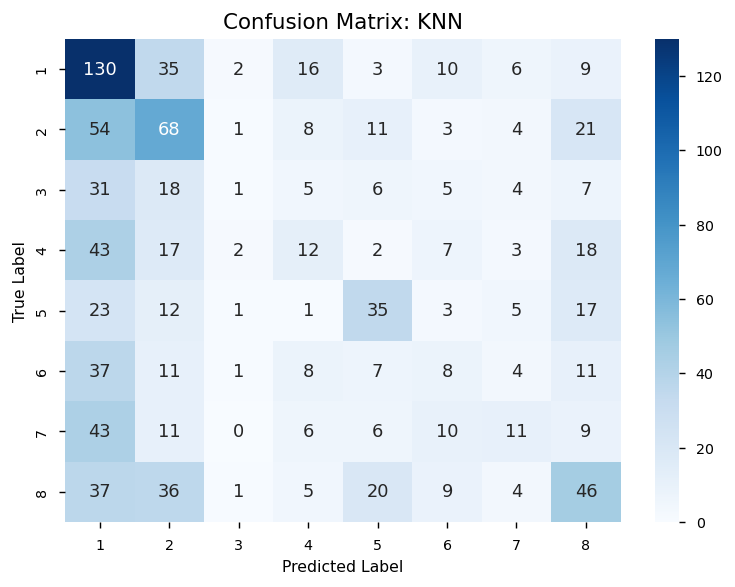

In [23]:
print_scores(gs_knno_pred, gs_knno)
scores = pd.concat([scores,get_scores(gs_knno_pred, "KNN", gs_knno.best_score_)])
plot_cm(gs_knno_pred, "KNN")

## MNB

In [24]:
pipe_mnb = Pipeline([
    ('count', CountVectorizer()),     # CountVectorizer 
    ('classifier', MultinomialNB()),  # 
])

## Uses values of default params as grid search values
grid_mnb = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
    "classifier__alpha": [.5]
}

gs_mnb = GridSearchCV(pipe_mnb, grid_mnb, n_jobs=-1, cv=10, scoring=score_func)

gs_mnb.fit(X_train, Y_train)
gs_mnb_pred = gs_mnb.predict(X_dev)


In [25]:
print_scores(gs_mnb_pred, gs_mnb)
scores = pd.concat([scores,get_scores(gs_mnb_pred, "MultinomialNB", gs_mnb.best_score_)])


Best parameters: 
{'classifier__alpha': 0.5, 'count__ngram_range': (1, 1), 'count__stop_words': None}
------------------------
Accuracy:          0.35
Macro F1:          0.2985
Macro Recall:      0.2981
Macro Precision:   0.3383
Best Train Score:  0.3493


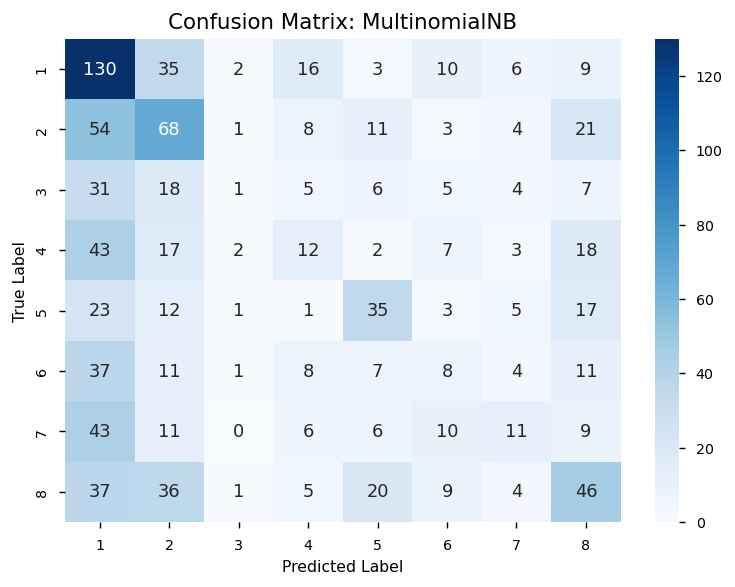

In [26]:
plot_cm(gs_knno_pred, "MultinomialNB")

## SGD

In [27]:
pipe_sgd = Pipeline([
    ('count', CountVectorizer()),
    ('sgd', SGDClassifier(random_state=RANDOM_STATE, max_iter=3000)),
])

grid_sgd = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
    "sgd__loss": ['log'],    
}

gs_sgd = GridSearchCV(pipe_sgd, grid_sgd, n_jobs=-1, cv=10, scoring=score_func)
gs_sgd.fit(X_train, Y_train)

gs_sgd_pred = gs_sgd.predict(X_dev)



In [28]:
print_scores(gs_sgd_pred, gs_sgd)
get_scores(gs_sgd_pred, "SGD", gs_sgd.best_score_)

scores = pd.concat([scores,get_scores(gs_sgd_pred, "SGDClassifier", gs_sgd.best_score_)])


Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None, 'sgd__loss': 'log'}
------------------------
Accuracy:          0.355
Macro F1:          0.3144
Macro Recall:      0.309
Macro Precision:   0.3483
Best Train Score:  0.3558


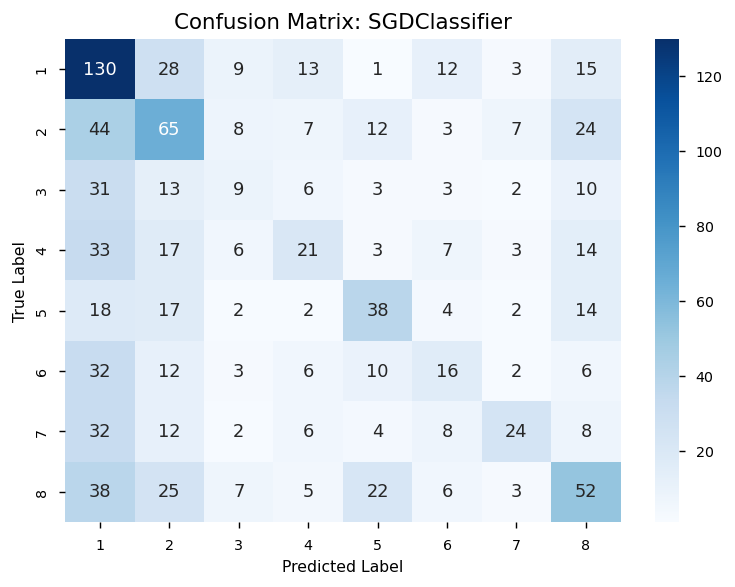

In [29]:
plot_cm(gs_sgd_pred, "SGDClassifier")

## LR

In [30]:
pipe_lr = Pipeline([
    ('count', CountVectorizer()),
    ('lr', LogisticRegression(random_state=RANDOM_STATE, max_iter=2000)),
])

grid_lr = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
    "lr__solver": ['lbfgs'],
    "lr__multi_class": ['multinomial'],
    #"lr__": [],
}

gs_lr = GridSearchCV(pipe_lr, grid_lr, n_jobs=-1, cv=10, scoring=score_func)

gs_lr.fit(X_train, Y_train)
gs_lr_pred = gs_lr.predict(X_dev)



In [31]:
print_scores(gs_lr_pred, gs_lr)
get_scores(gs_lr_pred, "LogisticRegression", gs_lr.best_score_)

scores = pd.concat([scores,get_scores(gs_lr_pred, "LogisticRegression", gs_lr.best_score_)])


Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None, 'lr__multi_class': 'multinomial', 'lr__solver': 'lbfgs'}
------------------------
Accuracy:          0.35
Macro F1:          0.3164
Macro Recall:      0.3124
Macro Precision:   0.336
Best Train Score:  0.3571


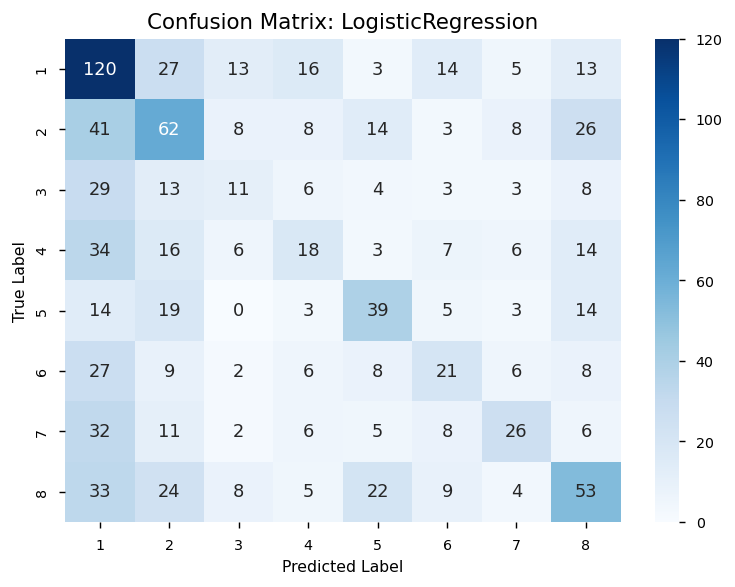

In [32]:
plot_cm(gs_lr_pred, "LogisticRegression")

## DT

In [33]:

pipe_dt = Pipeline([
    ('count', CountVectorizer()),
    ('dt', DecisionTreeClassifier(random_state=RANDOM_STATE)),
])

grid_dt = {
    "count__ngram_range": [(1,1), (2,4)],
    "count__stop_words": ["english", None],
    "dt__criterion": ['gini'],
    #"dt__": [],
    
}

gs_dt = GridSearchCV(pipe_dt, grid_dt, n_jobs=-1, cv=10, scoring=score_func)

gs_dt.fit(X_train, Y_train)
gs_dt_pred = gs_dt.predict(X_dev)


In [34]:
print_scores(gs_dt_pred, gs_dt)
get_scores(gs_dt_pred, "DecisionTreeClassifier", gs_dt.best_score_)

scores = pd.concat([scores,get_scores(gs_dt_pred, "DecisionTreeClassifier", gs_dt.best_score_)])


Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': 'english', 'dt__criterion': 'gini'}
------------------------
Accuracy:          0.304
Macro F1:          0.2739
Macro Recall:      0.272
Macro Precision:   0.2849
Best Train Score:  0.293


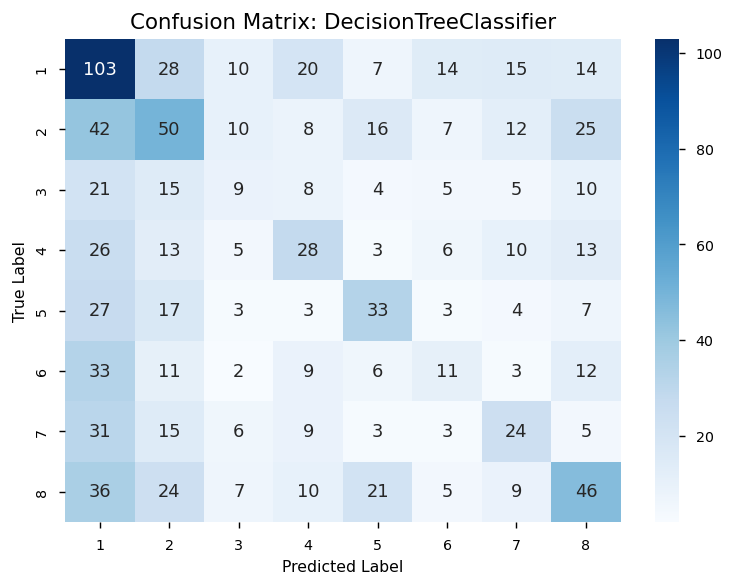

In [35]:
plot_cm(gs_dt_pred, "DecisionTreeClassifier")

## GB

In [36]:

pipe_gb = Pipeline([
    ('count', CountVectorizer()),
    ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE)),
])

grid_gb = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
    "gb__loss": ['deviance'],
    "gb__n_estimators": [200],
    "gb__learning_rate": [.25],    
}

gs_gb = GridSearchCV(pipe_gb, grid_gb, n_jobs=-1, cv=10, scoring=score_func)

gs_gb.fit(X_train, Y_train)
gs_gb_pred = gs_gb.predict(X_dev)


In [37]:
print_scores(gs_gb_pred, gs_gb)
get_scores(gs_gb_pred, "GradientBoostingClassifier", gs_gb.best_score_)

scores = pd.concat([scores,get_scores(gs_gb_pred, "GradientBoostingClassifier", gs_dt.best_score_)])


Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None, 'gb__learning_rate': 0.25, 'gb__loss': 'deviance', 'gb__n_estimators': 200}
------------------------
Accuracy:          0.348
Macro F1:          0.3076
Macro Recall:      0.299
Macro Precision:   0.3745
Best Train Score:  0.3344


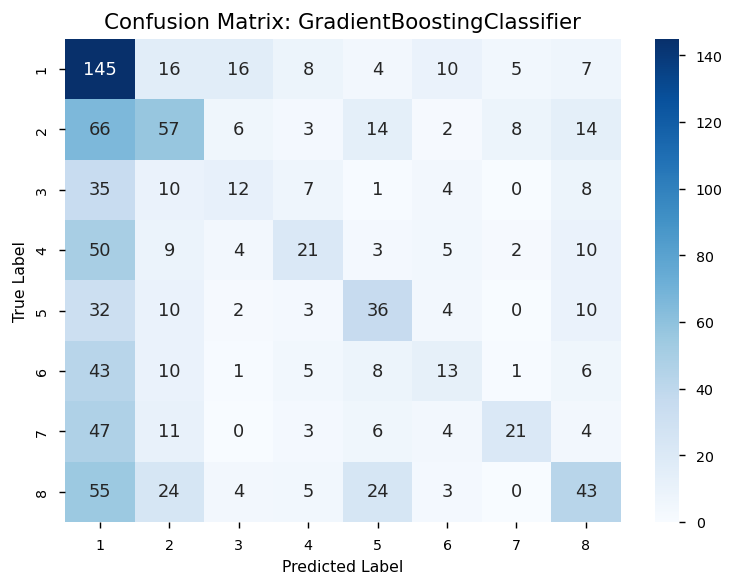

In [38]:
plot_cm(gs_gb_pred, "GradientBoostingClassifier")

## SVM

In [39]:

pipe_sv = Pipeline([
    ('count', CountVectorizer()),
    ('svc', SVC(random_state=RANDOM_STATE)),
])

grid_sv = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
    "svc__kernel": ['linear'],
    "svc__decision_function_shape": ['ovo'],
}

gs_sv = GridSearchCV(pipe_sv, grid_sv, n_jobs=-1, cv=10, scoring=score_func)

gs_sv.fit(X_train, Y_train)
gs_sv_pred = gs_sv.predict(X_dev)


In [40]:
print_scores(gs_sv_pred, gs_sv)
get_scores(gs_sv_pred, "SVC", gs_sv.best_score_)

scores = pd.concat([scores,get_scores(gs_sv_pred, "SVC", gs_sv.best_score_)])


Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None, 'svc__decision_function_shape': 'ovo', 'svc__kernel': 'linear'}
------------------------
Accuracy:          0.357
Macro F1:          0.3184
Macro Recall:      0.3137
Macro Precision:   0.3448
Best Train Score:  0.3529


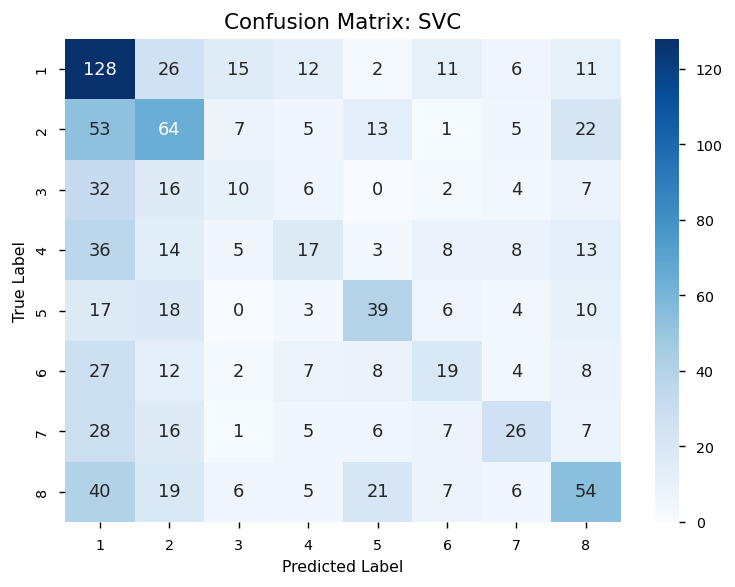

In [41]:
plot_cm(gs_sv_pred, "SVC")

## VotingClassifier

In [42]:
vc = VotingClassifier(
    estimators=[('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, solver='lbfgs', multi_class='multinomial')), 
                ('sg', SGDClassifier(random_state=RANDOM_STATE, loss='log')), 
                ('nb', MultinomialNB(alpha=.5)),
                ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE, loss='deviance', n_estimators=200, learning_rate=.25)),
                ('sv', SVC(random_state=RANDOM_STATE, kernel='linear', decision_function_shape='ovo'))
               ],
    voting='hard'
)

vc_pipe = Pipeline([
        ('count', CountVectorizer()),    
        ('vc', vc)
    ])


grid_vc = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None]
}

gs_vc = GridSearchCV(vc_pipe, grid_vc, n_jobs=-1, cv=10, scoring=score_func)

gs_vc.fit(X_train, Y_train)
gs_vc_pred = gs_vc.predict(X_dev)



In [43]:
print_scores(gs_vc_pred, gs_vc)
get_scores(gs_vc_pred, "VotingClassifier", gs_vc.best_score_)

scores = pd.concat([scores,get_scores(gs_vc_pred, "VotingClassifier", gs_vc.best_score_)])


Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None}
------------------------
Accuracy:          0.366
Macro F1:          0.323
Macro Recall:      0.3179
Macro Precision:   0.3606
Best Train Score:  0.3572


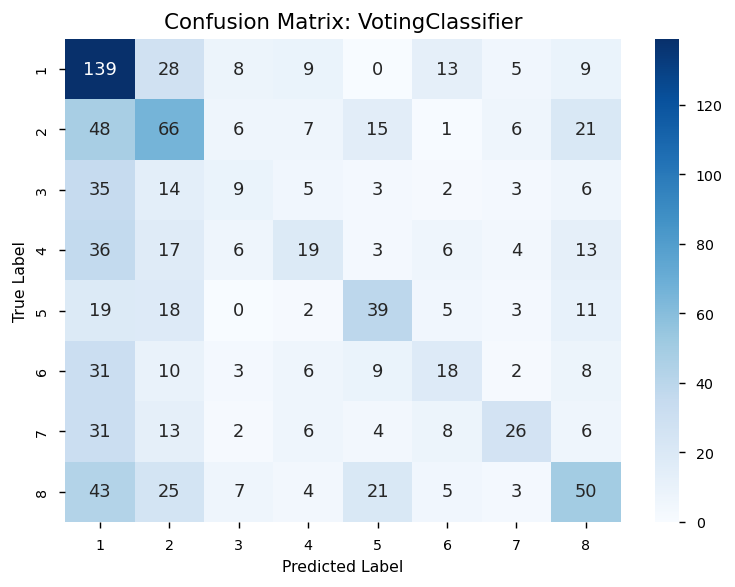

In [44]:
plot_cm(gs_vc_pred, "VotingClassifier")

## RF

In [45]:

pipe_rf = Pipeline([
    ('count', CountVectorizer()),
    ('rf', RandomForestClassifier(random_state=RANDOM_STATE)),
])

grid_rf = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
    "rf__n_estimators": [200],
    "rf__criterion": ['gini'],

}

gs_rf = GridSearchCV(pipe_rf, grid_rf, n_jobs=-1, cv=10, scoring=score_func)

gs_rf.fit(X_train, Y_train)
gs_rf_pred = gs_rf.predict(X_dev)


In [46]:
print_scores(gs_rf_pred, gs_rf)
get_scores(gs_rf_pred, "RandomForestClassifier", gs_rf.best_score_)

scores = pd.concat([scores,get_scores(gs_rf_pred, "RandomForestClassifier", gs_rf.best_score_)])


Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None, 'rf__criterion': 'gini', 'rf__n_estimators': 200}
------------------------
Accuracy:          0.333
Macro F1:          0.2942
Macro Recall:      0.2937
Macro Precision:   0.3075
Best Train Score:  0.3108


In [47]:
scores.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

,Model,Accuracy,Recall,Precision,F1,Train Accuracy,F1 Anger,F1 Anticipation,F1 Digust,F1 Fear,...,Recall Surprise,Recall Trust,Precision Anger,Precision Anticipation,Precision Digust,Precision Fear,Precision Joy,Precision Sadness,Precision Surprise,Precision Trust
0,VotingClassifier,0.366,0.317853,0.360623,0.323022,0.357214,0.468803,0.365651,0.152542,0.234568,...,0.270833,0.316456,0.363874,0.345550,0.219512,0.327586,0.414894,0.310345,0.500000,0.403226
1,SVC,0.357,0.313687,0.344802,0.318368,0.352929,0.447552,0.360563,0.162602,0.207317,...,0.270833,0.341772,0.354571,0.345946,0.217391,0.283333,0.423913,0.311475,0.412698,0.409091
2,SGDClassifier,0.355,0.309006,0.348255,0.314398,0.355786,0.456942,0.362117,0.146341,0.247059,...,0.250000,0.329114,0.363128,0.343915,0.195652,0.318182,0.408602,0.271186,0.521739,0.363636
3,MultinomialNB,0.350,0.298077,0.338255,0.298526,0.349286,0.452703,0.346591,0.090909,0.250000,...,0.156250,0.367089,0.351706,0.335165,0.151515,0.357143,0.395833,0.296875,0.441176,0.376623
4,LogisticRegression,0.350,0.312385,0.336039,0.316436,0.357143,0.443623,0.353276,0.173228,0.209302,...,0.270833,0.335443,0.363636,0.342541,0.220000,0.264706,0.397959,0.300000,0.426230,0.373239
5,GradientBoostingClassifier,0.348,0.298966,0.374477,0.307632,0.293000,0.423977,0.359621,0.196721,0.264151,...,0.218750,0.272152,0.306554,0.387755,0.266667,0.381818,0.375000,0.288889,0.567568,0.421569
6,RandomForestClassifier,0.333,0.293683,0.307503,0.294161,0.310786,0.400794,0.365217,0.125000,0.258706,...,0.208333,0.417722,0.344710,0.360000,0.200000,0.268041,0.339806,0.238095,0.327869,0.381503
7,KNN,0.311,0.250373,0.262170,0.239229,0.301857,0.426929,0.359788,0.023256,0.145455,...,0.114583,0.291139,0.326633,0.326923,0.111111,0.196721,0.388889,0.145455,0.268293,0.333333
8,DecisionTreeClassifier,0.304,0.272021,0.284928,0.273933,0.293000,0.388679,0.291545,0.139535,0.281407,...,0.250000,0.291139,0.322884,0.289017,0.173077,0.294737,0.354839,0.203704,0.292683,0.348485
9,KNN Baseline,0.245,0.204315,0.226789,0.203746,0.259571,0.343925,0.265625,0.081633,0.147368,...,0.156250,0.253165,0.283951,0.238318,0.190476,0.162791,0.371429,0.063830,0.288462,0.215054


# UMAP

Testing embedding on UMAP. 

In [127]:
import umap
import umap.plot

In [128]:
cv_umap = TfidfVectorizer(min_df=.0005, ngram_range=(1,1))
umap_vec = cv_umap.fit_transform(X_train)

In [129]:
embedding = umap.UMAP(n_components=2, metric='jaccard', 
                      min_dist=0.01, 
                      n_neighbors=15,).fit_transform(umap_vec)

/opt/homebrew/Caskroom/miniforge/base/envs/dm/lib/python3.9/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/homebrew/Caskroom/miniforge/base/envs/dm/lib/python3.9/site-packages/pynndescent/pynndescent_.py:891: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/dm/lib/python3.9/site-packages/umap/umap_.py:132: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = 1 has removed 39111 edges.
It has fully disconnected 1901 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.


In [130]:
u_plot = pd.DataFrame(embedding)
u_plot['label'] = Y_train

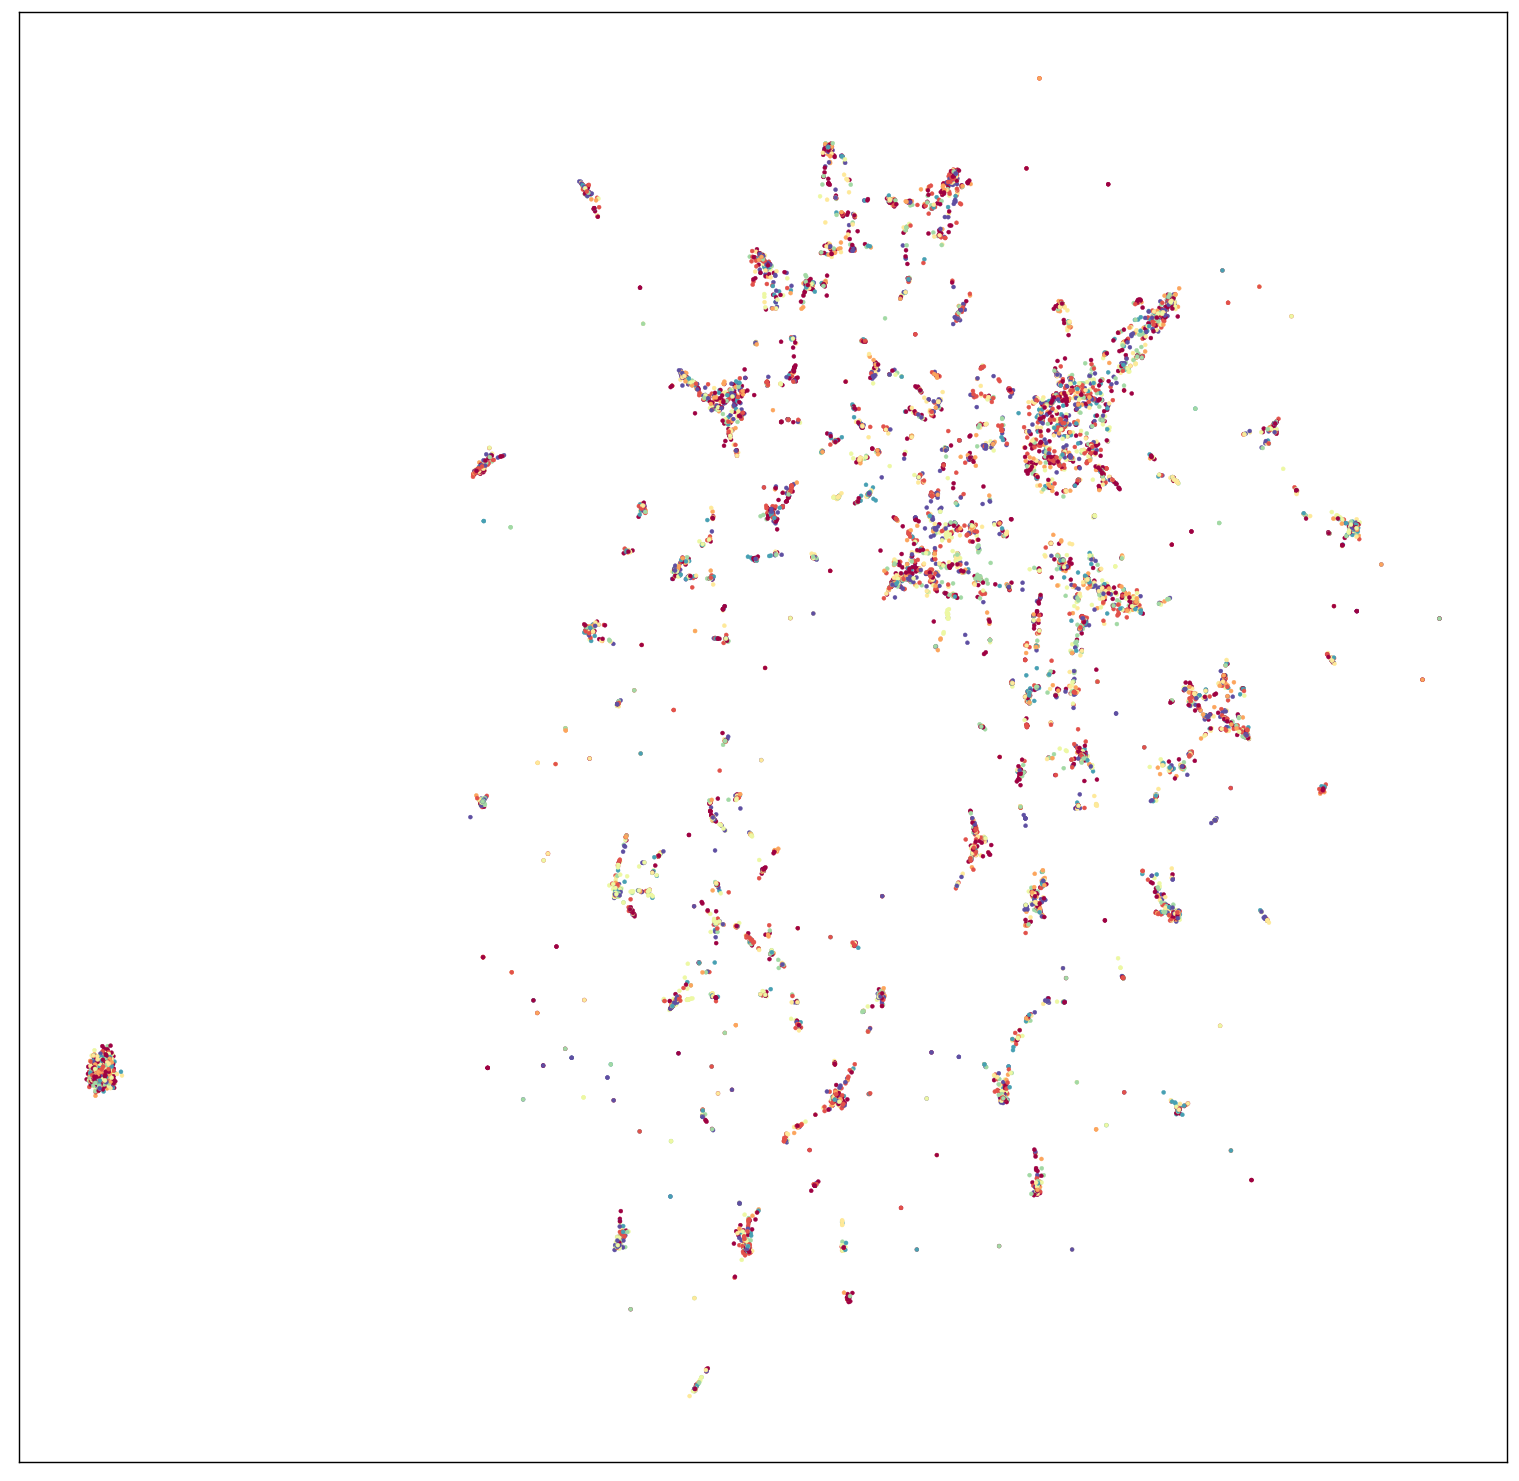

In [132]:
fig, ax = plt.subplots(figsize=(15,15))

ax.scatter(x=u_plot[0], y=u_plot[1], c=u_plot['label'], cmap='Spectral',\
           s=5, marker="o")
ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [53]:
len(cv_umap.stop_words_)

4801

In [54]:
test_umap = cv_umap.transform(X_dev)

In [55]:
test_embedding = umap.UMAP(n_components=2, metric='hellinger', 
                      min_dist=0.01, 
                      n_neighbors=35,).fit_transform(test_umap)

/opt/homebrew/Caskroom/miniforge/base/envs/dm/lib/python3.9/site-packages/umap/umap_.py:125: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 957854 edges.
It has only fully disconnected 25 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


In [56]:
u_plot2 = pd.DataFrame(test_embedding)
u_plot2['label'] = Y_dev

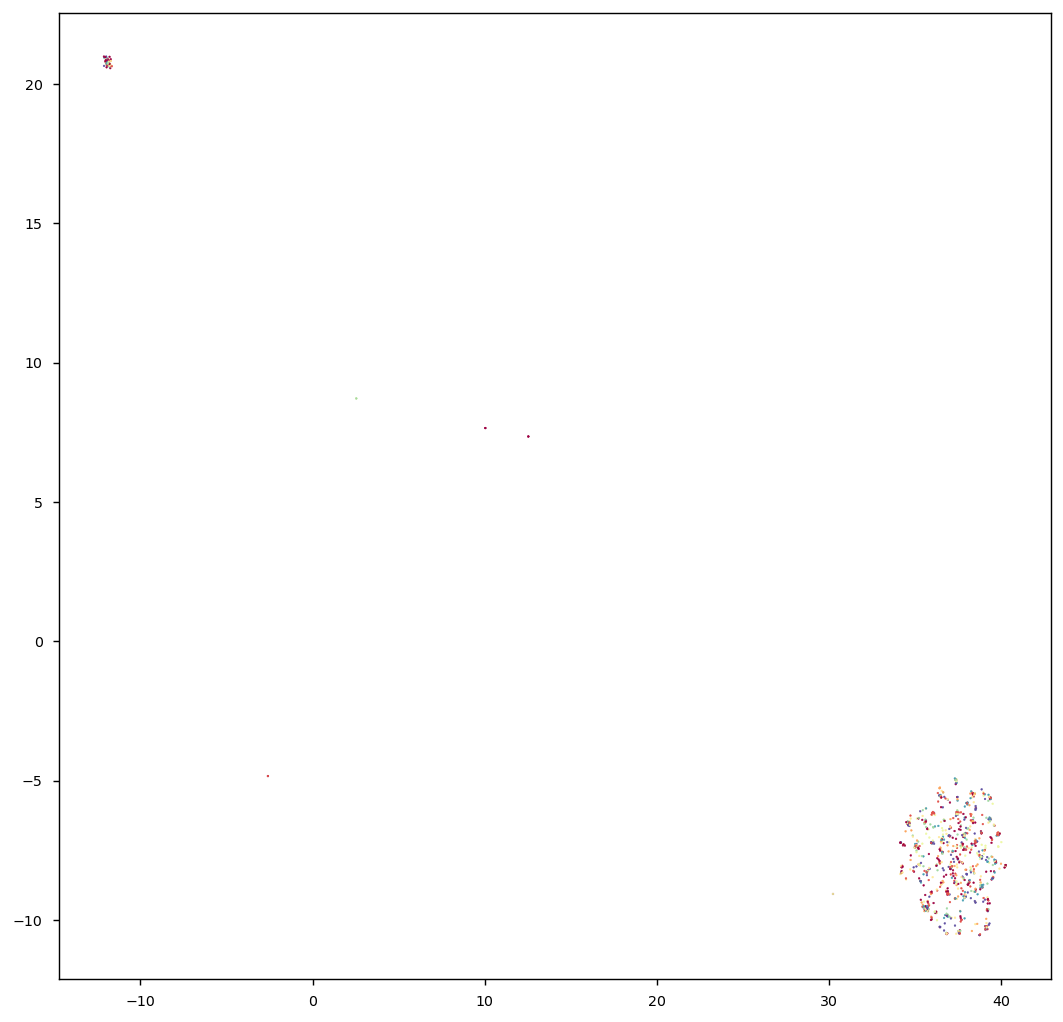

In [57]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(x=u_plot2[0], y=u_plot2[1], c=u_plot2['label'], cmap='Spectral',\
           s=1, marker="o")


plt.show()